In [1]:
import os
import json
import random
from PIL import Image
import numpy as np
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch


import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import json
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms import functional as TF
import torch.nn.functional as F
import random
import torch
import torch.nn as nn
from datetime import datetime


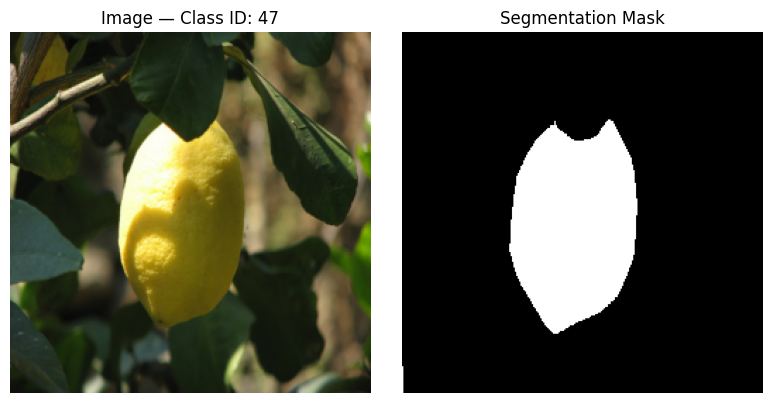

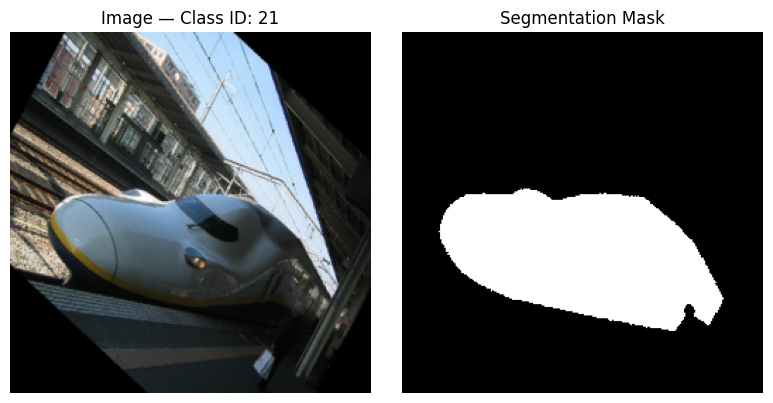

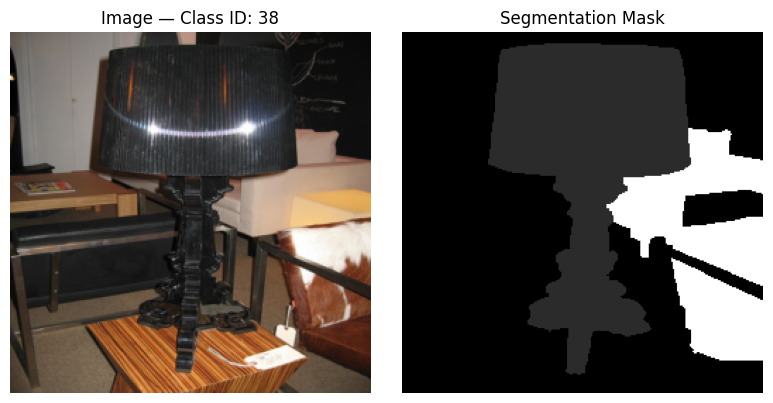

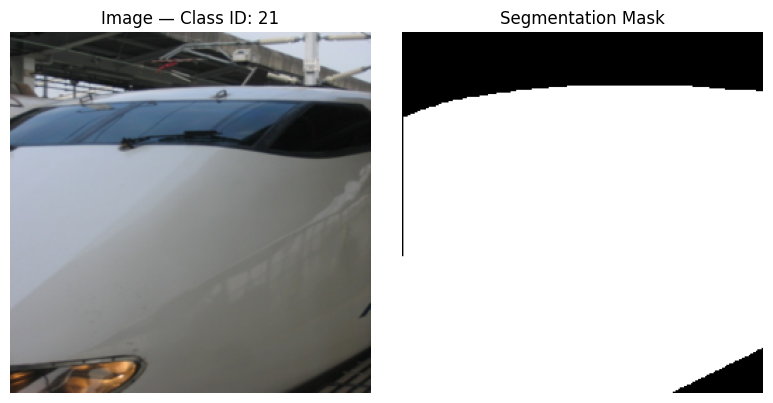

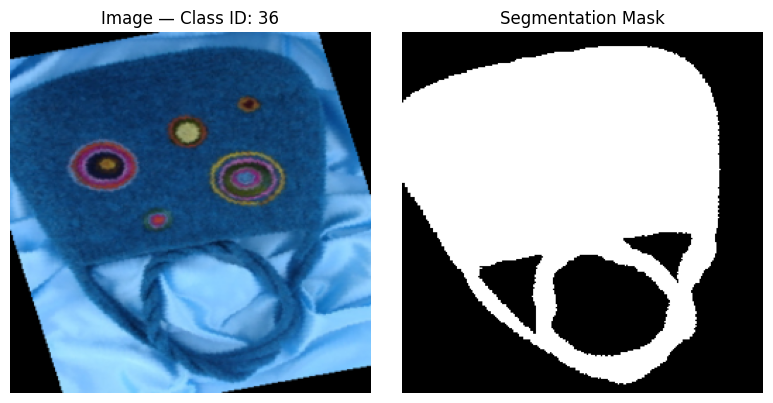

In [3]:
class SemiSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, annotation_path, transform=None, mask_transform=None):
        with open(annotation_path, 'r') as f:
            self.annotations = json.load(f)
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.mask_transform = mask_transform

        self.samples = [(ann['image'], ann['mask'], ann['class_id']) for ann in self.annotations]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_name, mask_name, class_id = self.samples[idx]
        image = Image.open(os.path.join(self.images_dir, image_name)).convert("RGB")
        mask = Image.open(os.path.join(self.masks_dir, mask_name))

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, class_id, mask

# Paths
original_dir = "train-semi"
original_masks_dir = "train-semi-segmentation"
original_annotations = "train_semi_annotations_with_seg_ids.json"

augmented_dir = "augmented"
augmented_images_dir = os.path.join(augmented_dir, "train-semi")
augmented_masks_dir = os.path.join(augmented_dir, "train-semi-segmentation")
augmented_annotations = os.path.join(augmented_dir, "annotations.json")

image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x[0] if x.shape[0] == 1 else x.max(dim=0)[0]),
])
# Load datasets
original_dataset = SemiSegmentationDataset(
    images_dir=original_dir,
    masks_dir=original_masks_dir,
    annotation_path=original_annotations,
    transform=image_transform,
    mask_transform=mask_transform
)


augmented_dataset = SemiSegmentationDataset(
    images_dir=augmented_images_dir,
    masks_dir=augmented_masks_dir,
    annotation_path=augmented_annotations,
    transform=image_transform,
    mask_transform=mask_transform
)

# Combine and make DataLoader
combined_dataset = ConcatDataset([original_dataset, augmented_dataset])
dataloader = DataLoader(combined_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

def plot_segmentation(image, mask, class_id=None):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    # Convert tensor to PIL image, then to numpy array for imshow
    img_np = np.array(to_pil_image(image.cpu()))
    axs[0].imshow(img_np)
    axs[0].set_title(f"Image" + (f" — Class ID: {class_id}" if class_id is not None else ""))
    axs[0].axis("off")

    axs[1].imshow(mask.cpu(), cmap="gray")
    axs[1].set_title("Segmentation Mask")
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()

images, class_ids, masks = next(iter(dataloader))
for i in range(5):
    plot_segmentation(images[i], masks[i], class_ids[i])

In [3]:
# --- Attention Block ---
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

# --- Conv Block with Dropout + Attention ---
def conv_block(in_c, out_c, dropout=0.0):
    layers = [
        nn.Conv2d(in_c, out_c, 3, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, 3, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
    ]
    if dropout > 0:
        layers.append(nn.Dropout(dropout))
    layers.append(SEBlock(out_c))
    return nn.Sequential(*layers)

# --- Full UNet Model ---
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=50):
        super(UNet, self).__init__()

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.up3 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec3 = conv_block(1024, 512, dropout=0.3)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = conv_block(512, 256, dropout=0.2)

        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec1 = conv_block(256, 128, dropout=0.1)

        self.up0 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec0 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d3 = self.up3(b)
        d3 = torch.cat([d3, e4], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e3], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)

        d0 = self.up0(d1)
        d0 = torch.cat([d0, e1], dim=1)
        d0 = self.dec0(d0)

        out = self.final(d0)
        return F.softmax(out, dim=1)


In [4]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = F.softmax(preds, dim=1)
        preds_flat = preds.view(preds.size(0), preds.size(1), -1)
        targets_flat = F.one_hot(targets, preds.size(1)).permute(0, 3, 1, 2).reshape_as(preds_flat)

        intersection = (preds_flat * targets_flat).sum(2)
        union = preds_flat.sum(2) + targets_flat.sum(2)

        dice_score = (2 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice_score.mean()

# Combined loss
def combined_loss(preds, targets):
    targets = torch.clamp(targets, 0, preds.size(1) - 1) 
    ce = nn.CrossEntropyLoss()(preds, targets)
    dice = DiceLoss()(preds, targets)
    return ce + dice


In [5]:
def dice_score(preds, targets, smooth=1.0):
    preds = torch.argmax(preds, dim=1)
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    intersection = (preds_flat == targets_flat).float().sum()
    total = preds_flat.numel() + targets_flat.numel()
    return (2.0 * intersection + smooth) / (total + smooth)

def iou_score(preds, targets, smooth=1.0):
    preds = torch.argmax(preds, dim=1)
    intersection = ((preds == targets) & (targets > 0)).float().sum()
    union = ((preds > 0) | (targets > 0)).float().sum()
    return (intersection + smooth) / (union + smooth)

def validate(model, val_loader, device):
    model.eval()
    total_dice, total_iou, total_loss = 0, 0, 0

    with torch.no_grad():
        for images, class_id, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            masks = masks.long()

            outputs = model(images)
            total_loss += combined_loss(outputs, masks).item()
            total_dice += dice_score(outputs, masks).item()
            total_iou += iou_score(outputs, masks).item()

    n = len(val_loader)
    print(f"[Validation] Loss: {total_loss/n:.4f} | Dice: {total_dice/n:.4f} | IoU: {total_iou/n:.4f}")
    return total_loss/n, total_dice/n, total_iou/n


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", device)
model = UNet(in_channels=3, out_channels=50).to(device)
# model = SimpleUNet(232 + 1).to(device)
criterion = nn.CrossEntropyLoss()  # expects (B, C, H, W) logits and (B, H, W) target
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

using cuda


In [ ]:
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, class_id, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        masks = masks.to(device).long()
        masks = torch.clamp(masks, min=0, max=49)
        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    validate(model, dataloader, device)


Unique predicted values: tensor([0], device='cuda:0')


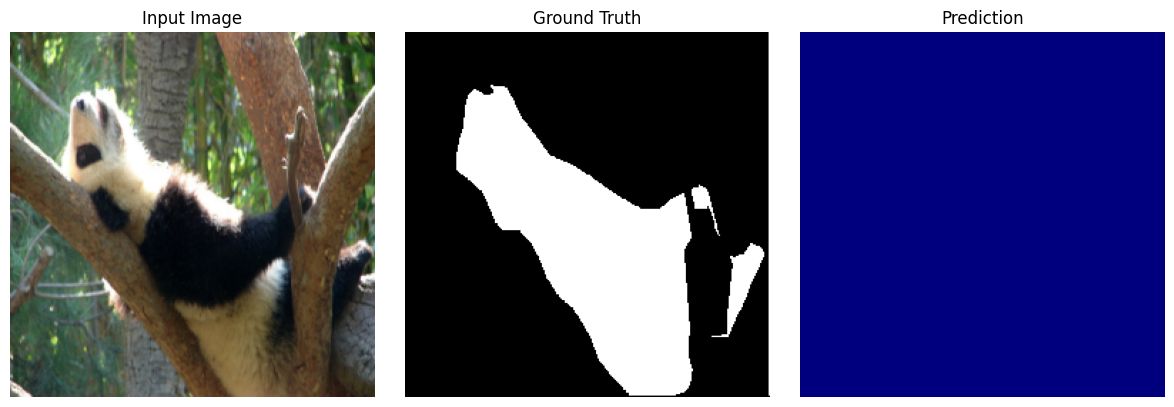

Unique predicted values: tensor([0], device='cuda:0')


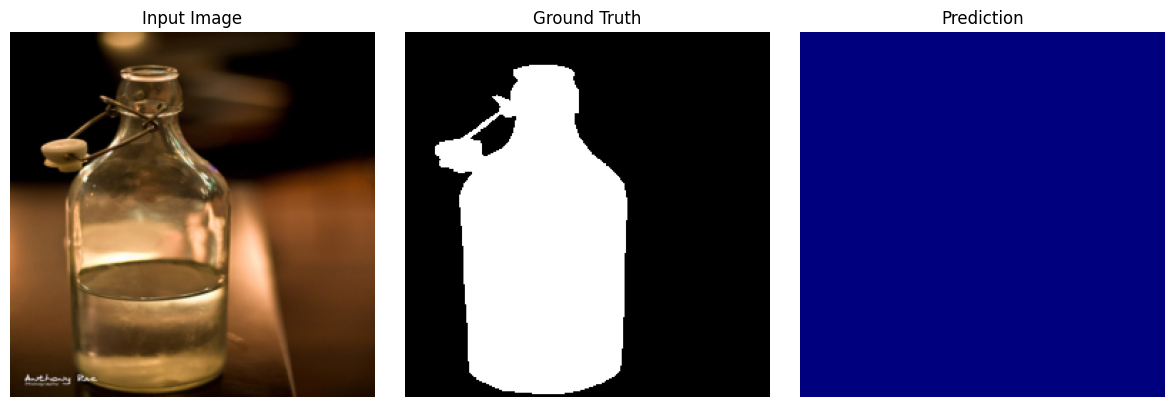

Unique predicted values: tensor([0], device='cuda:0')


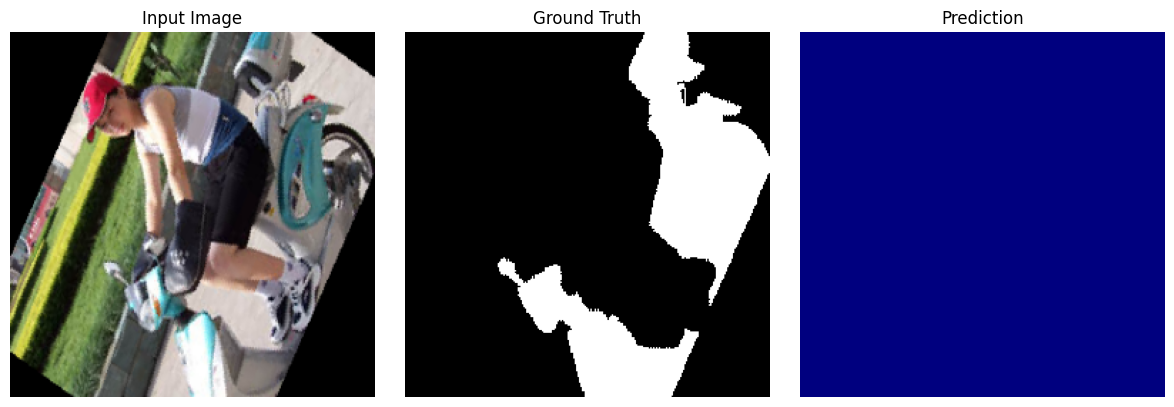

Unique predicted values: tensor([0], device='cuda:0')


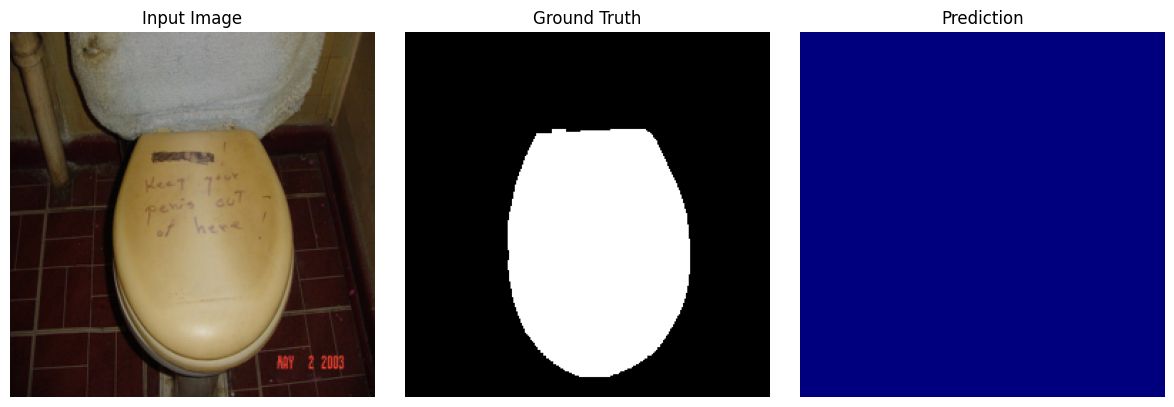

Unique predicted values: tensor([0], device='cuda:0')


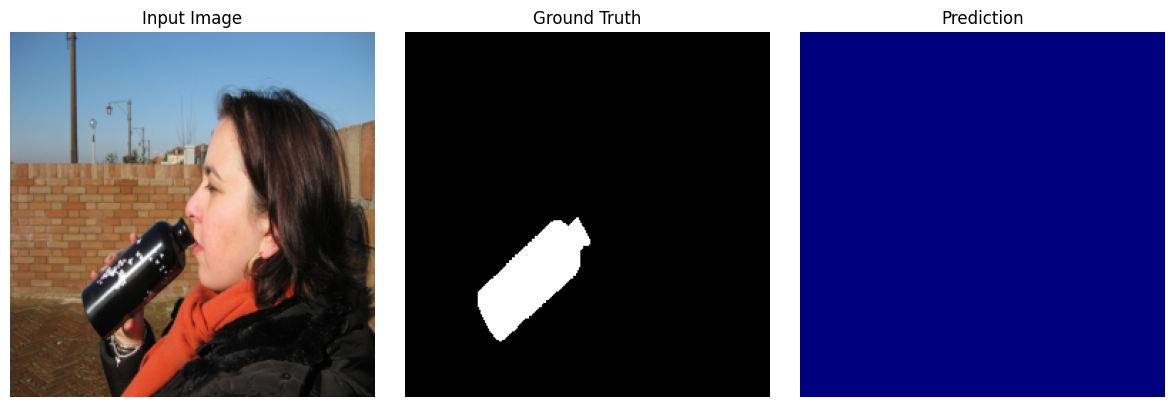

In [ ]:
def visualize_predictions(model, dataloader, device, num_samples=5):
    model.eval()
    shown = 0
    with torch.no_grad():
        for images, class_ids, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                if shown >= num_samples:
                    return
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                print("Unique predicted values:", torch.unique(preds))
                # Input image
                img_np = images[i].cpu().permute(1, 2, 0).numpy()
                img_np = (img_np * 255).astype('uint8')
                axs[0].imshow(img_np)
                axs[0].set_title("Input Image")
                axs[0].axis("off")
                # Ground truth mask
                axs[1].imshow(masks[i].cpu(), cmap='gray')
                axs[1].set_title("Ground Truth")
                axs[1].axis("off")
                # Predicted mask
                axs[2].imshow(preds[i].cpu(), cmap='jet')
                axs[2].set_title("Prediction")
                axs[2].axis("off")
                plt.tight_layout()
                plt.show()
                shown += 1

# Example usage:
visualize_predictions(model, dataloader, device, num_samples=5)